In [1]:
import pandas as pd
import quandl, math, datetime
import numpy as np
from sklearn import preprocessing, model_selection, svm
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from matplotlib import style
import pickle

style.use('ggplot')

In [2]:
df = quandl.get('WIKI/GOOGL')
print(df.head())

              Open    High     Low    Close      Volume  Ex-Dividend  \
Date                                                                   
2004-08-19  100.01  104.06   95.96  100.335  44659000.0          0.0   
2004-08-20  101.01  109.08  100.50  108.310  22834300.0          0.0   
2004-08-23  110.76  113.48  109.05  109.400  18256100.0          0.0   
2004-08-24  111.24  111.60  103.57  104.870  15247300.0          0.0   
2004-08-25  104.76  108.00  103.88  106.000   9188600.0          0.0   

            Split Ratio  Adj. Open  Adj. High   Adj. Low  Adj. Close  \
Date                                                                   
2004-08-19          1.0  50.159839  52.191109  48.128568   50.322842   
2004-08-20          1.0  50.661387  54.708881  50.405597   54.322689   
2004-08-23          1.0  55.551482  56.915693  54.693835   54.869377   
2004-08-24          1.0  55.792225  55.972783  51.945350   52.597363   
2004-08-25          1.0  52.542193  54.167209  52.100830   53.1

In [3]:
df.columns[8]
df = df[['Adj. Open','Adj. High', 'Adj. Low','Adj. Close','Adj. Volume',]]
df['HL_PCT']=(df['Adj. High'] - df['Adj. Close'])/df['Adj. Close'] * 100
df['PCT_change']=(df['Adj. Close'] - df['Adj. Open'])/df['Adj. Open'] * 100
df = df[['Adj. Close', 'HL_PCT', 'PCT_change', 'Adj. Volume']]
print(df.head())
print(len(df))

            Adj. Close    HL_PCT  PCT_change  Adj. Volume
Date                                                     
2004-08-19   50.322842  3.712563    0.324968   44659000.0
2004-08-20   54.322689  0.710922    7.227007   22834300.0
2004-08-23   54.869377  3.729433   -1.227880   18256100.0
2004-08-24   52.597363  6.417469   -5.726357   15247300.0
2004-08-25   53.164113  1.886792    1.183658    9188600.0
3424


In [4]:
forecast_col = 'Adj. Close'
df.fillna(-99999, inplace=True)
forecast_out = int(math.ceil(0.01*len(df))) #in days
print(forecast_out)

df['label'] = df[forecast_col].shift(-forecast_out)
print(df.head())
print(df.tail())

35
            Adj. Close    HL_PCT  PCT_change  Adj. Volume      label
Date                                                                
2004-08-19   50.322842  3.712563    0.324968   44659000.0  69.078238
2004-08-20   54.322689  0.710922    7.227007   22834300.0  67.839414
2004-08-23   54.869377  3.729433   -1.227880   18256100.0  68.912727
2004-08-24   52.597363  6.417469   -5.726357   15247300.0  70.668146
2004-08-25   53.164113  1.886792    1.183658    9188600.0  71.219849
            Adj. Close    HL_PCT  PCT_change  Adj. Volume  label
Date                                                            
2018-03-21     1094.00  1.343693    0.130884    1990515.0    NaN
2018-03-22     1053.15  2.921711   -2.487014    3418154.0    NaN
2018-03-23     1026.55  3.918952   -2.360729    2413517.0    NaN
2018-03-26     1054.09  0.491419    0.332191    3272409.0    NaN
2018-03-27     1006.94  5.720301   -5.353887    2940957.0    NaN


In [5]:
X = np.array(df.drop(['label'],1))
print("X : {}".format(X))
print("len of X : {}\n\n\n".format(len(X)))
X = preprocessing.scale(X)
X = X[:-forecast_out]
print("X : {}".format(X))
print("len of X : {}\n\n\n".format(len(X)))
X_lately = X[-forecast_out:]
print("X_lately : {}".format(X_lately))
print("len of X_lately : {}\n\n\n".format(len(X_lately)))

X : [[ 5.03228418e+01  3.71256291e+00  3.24967503e-01  4.46590000e+07]
 [ 5.43226889e+01  7.10922353e-01  7.22700723e+00  2.28343000e+07]
 [ 5.48693765e+01  3.72943327e+00 -1.22788010e+00  1.82561000e+07]
 ...
 [ 1.02655000e+03  3.91895183e+00 -2.36072933e+00  2.41351700e+06]
 [ 1.05409000e+03  4.91419139e-01  3.32191129e-01  3.27240900e+06]
 [ 1.00694000e+03  5.72030111e+00 -5.35388664e+00  2.94095700e+06]]
len of X : 3424



X : [[-1.39187095  2.33516806  0.23254018  4.46712802]
 [-1.37635178 -0.31135438  4.81828847  1.8207495 ]
 [-1.37423066  2.35004252 -0.79917922  1.26561472]
 ...
 [ 2.99737935 -0.50090092  0.33301614 -0.61156746]
 [ 2.7553098   0.01505419 -0.46778619 -0.24489949]
 [ 2.55960556  2.87565464 -1.90605746 -0.49425191]]
len of X : 3389



X_lately : [[ 2.51580102 -0.13691121  0.1412663  -0.76234496]
 [ 2.57217657 -0.67086492  0.53002653 -0.57449085]
 [ 2.622965   -0.82441166  0.54990695 -0.7682545 ]
 [ 2.60236251 -0.51438062 -0.18213542 -0.7918798 ]
 [ 2.57822928 -0.30

In [6]:
y = np.array(df['label'])
print("y : {}".format(y))
df.dropna(inplace=True)
y = np.array(df['label'])
print("y : {}".format(y))
print(len(y))

y : [69.0782379  67.83941377 68.91272699 ...         nan         nan
         nan]
y : [  69.0782379    67.83941377   68.91272699 ... 1026.55       1054.09
 1006.94      ]
3389


In [7]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y,test_size=0.2) #20 %

print("X_train : \n{}\nLength of X_train : {}\n\n\n".format(X_train, len(X_train)))
print("y_train : \n{}\nLength of y_train : {}\n\n\n".format(y_train, len(y_train)))
print("X_test : \n{}\nLength of X_test : {}\n\n\n".format(X_test, len(X_test)))
print("y_test : \n{}\nLength of y_test : {}\n\n\n".format(y_test, len(y_test)))

X_train : 
[[-1.20753821  0.43594347  0.20792413  0.87856517]
 [-0.98665027 -0.47527849  0.30858596  0.80457469]
 [ 1.54977321 -0.67763854  0.13517837 -0.83667375]
 ...
 [ 1.29261069 -0.62099217  0.6364462  -0.64829666]
 [-0.47711546  0.255124   -0.56527963 -0.3811647 ]
 [-0.55573296  0.25791519 -0.75159674 -0.36762039]]
Length of X_train : 2711



y_train : 
[ 92.87670148 193.57253989 802.64       ... 733.25       304.93630917
 295.91345649]
Length of y_train : 2711



X_test : 
[[ 0.14559742 -0.43217213  0.00543942 -0.62736313]
 [ 0.39341487 -0.86994189  0.98124852 -0.64698746]
 [-0.70713003 -0.60866284  0.53039868 -0.32050026]
 ...
 [-0.97981989 -0.67824947  4.64152701  2.25831435]
 [-0.94874263 -0.0808004   1.475837    0.23640487]
 [-1.2201676  -0.14797989  0.31391888  1.16858557]]
Length of X_test : 678



y_test : 
[ 439.31111132  559.85        250.30266033  285.42608297  572.38188806
  765.89        417.58705122  220.42543219  311.52665293  541.8
  849.53        332.54152383  96

In [8]:
clf = svm.SVR()
clf.fit(X_train, y_train)
accuracy = clf.score(X_test, y_test)
print(accuracy)

0.8025178852631136


In [9]:
clf = svm.SVR(kernel = 'poly')
clf.fit(X_train, y_train)
accuracy = clf.score(X_test, y_test)
print(accuracy)


0.5679261250236202


In [10]:
clf = LinearRegression(n_jobs=-1)
clf.fit(X_train, y_train)

with open ('linearregression.pickle', 'wb') as f:
    pickle.dump(clf, f)

pickle_in = open('linearregression.pickle', 'rb')
clf = pickle.load(pickle_in)


accuracy = clf.score(X_test, y_test)
print(accuracy)

0.977343933280015


In [11]:
forecast_set = clf.predict(X_lately)
print("forecast_set is : \n{}\n\n".format(forecast_set))
print("forecast_out is : \n{}\n\n".format(forecast_out))
print("accuracy is : \n{}".format(accuracy))

forecast_set is : 
[1076.24729125 1091.02314074 1104.99764717 1099.32800017 1092.74418467
 1090.18792434 1088.69994149 1085.62875467 1079.35558451 1074.99348319
 1072.80222175 1092.82939553 1111.1271376  1115.13680271 1130.23381074
 1134.15025022 1132.58765129 1130.31833829 1132.01764145 1150.87933679
 1149.26988693 1159.66542155 1156.08657578 1164.07309376 1184.66340897
 1196.69164811 1190.50708967 1202.82587508 1208.35732603 1206.3432809
 1197.14090219 1202.70407629 1201.48974955 1136.81552532 1083.05466952]


forecast_out is : 
35


accuracy is : 
0.977343933280015


In [12]:
print(df.head())
df['Forecast'] = np.nan
print(df['Forecast'].head())
print(df.head())
print(df.tail())

            Adj. Close    HL_PCT  PCT_change  Adj. Volume      label
Date                                                                
2004-08-19   50.322842  3.712563    0.324968   44659000.0  69.078238
2004-08-20   54.322689  0.710922    7.227007   22834300.0  67.839414
2004-08-23   54.869377  3.729433   -1.227880   18256100.0  68.912727
2004-08-24   52.597363  6.417469   -5.726357   15247300.0  70.668146
2004-08-25   53.164113  1.886792    1.183658    9188600.0  71.219849
Date
2004-08-19   NaN
2004-08-20   NaN
2004-08-23   NaN
2004-08-24   NaN
2004-08-25   NaN
Name: Forecast, dtype: float64
            Adj. Close    HL_PCT  PCT_change  Adj. Volume      label  Forecast
Date                                                                          
2004-08-19   50.322842  3.712563    0.324968   44659000.0  69.078238       NaN
2004-08-20   54.322689  0.710922    7.227007   22834300.0  67.839414       NaN
2004-08-23   54.869377  3.729433   -1.227880   18256100.0  68.912727       NaN
2

In [13]:
last_date = df.iloc[-1].name
print(last_date)
last_unix = last_date.timestamp()
print(last_unix)
one_day = 86400
next_unix = last_unix + one_day
print(next_unix)

2018-02-05 00:00:00
1517788800.0
1517875200.0


In [14]:
for i in forecast_set:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += one_day
    df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)]+[i]
print(df.head())
print(df.tail())

            Adj. Close    HL_PCT  PCT_change  Adj. Volume      label  Forecast
Date                                                                          
2004-08-19   50.322842  3.712563    0.324968   44659000.0  69.078238       NaN
2004-08-20   54.322689  0.710922    7.227007   22834300.0  67.839414       NaN
2004-08-23   54.869377  3.729433   -1.227880   18256100.0  68.912727       NaN
2004-08-24   52.597363  6.417469   -5.726357   15247300.0  70.668146       NaN
2004-08-25   53.164113  1.886792    1.183658    9188600.0  71.219849       NaN
                     Adj. Close  HL_PCT  PCT_change  Adj. Volume  label  \
Date                                                                      
2018-03-07 19:00:00         NaN     NaN         NaN          NaN    NaN   
2018-03-08 19:00:00         NaN     NaN         NaN          NaN    NaN   
2018-03-09 19:00:00         NaN     NaN         NaN          NaN    NaN   
2018-03-10 19:00:00         NaN     NaN         NaN          NaN    NaN 

<function matplotlib.pyplot.show(*args, **kw)>

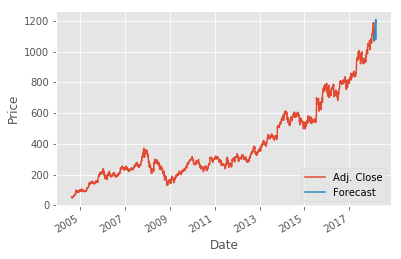

In [15]:
df['Adj. Close'].plot()
df['Forecast'].plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.rcParams["figure.figsize"] = (500,10)
plt.savefig("google_prediction")
plt.show